# evidential network

## load network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.linalg as LA
import numpy as np

from model import *
from Simulator import *

In [2]:
in_chn, equiv_dim, inv_dim, evid_dim = 2, 128, 128, 128
summary_net = InvariantNetwork(in_chn, equiv_dim, inv_dim)
evidential_net = EvidentialNetwork(inv_dim + 1, evid_dim, n_models=2)

In [3]:
params = torch.load('ckpt_ssp2dstp.pth')
summary_net.load_state_dict(params['summary_net'])
evidential_net.load_state_dict(params['evidential_net'])

<All keys matched successfully>

In [4]:
device = 'cuda:2'
summary_net = summary_net.to(device)
evidential_net = evidential_net.to(device)

## visualization

In [5]:
import matplotlib.pyplot as plt
models=[
    {'name': SSP, 'kwargs': {'incongruency': 'random'}}, 
    {'name': DSTP, 'kwargs': {'incongruency': 'random'}}
]

In [6]:
list_uncertainty = []
list_acc = []
n_nobs = 200
steps = [10 + 10*i for i in range(20)]
for n in steps:
    dataset = SSP_DDM_Dataset(n_obs=n, length=n_nobs, models=models)
    dataloader = DataLoader(dataset, batch_size=n_nobs)
    for i ,(m,p,x) in enumerate(dataloader):
        m, x = m.to(device), x.to(device)
    pre = evidential_net.predict(summary_net(x), to_numpy=False) 
    list_uncertainty.append(pre['uncertainty'].mean().item())
    list_acc.append((pre['m_probs'].argmax(dim=1)==m[:,1]).sum().item()/n_nobs)

KeyboardInterrupt: 

### Accuracy

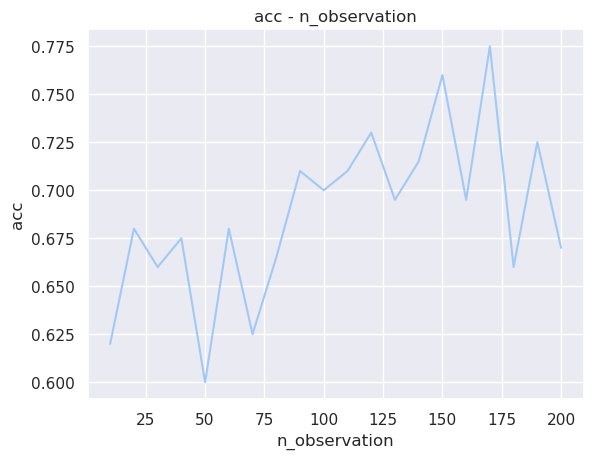

In [ ]:
plt.plot(steps, list_acc)
plt.ylabel('acc')
plt.xlabel('n_observation')
plt.title('acc - n_observation')
plt.show()

### Uncertainty

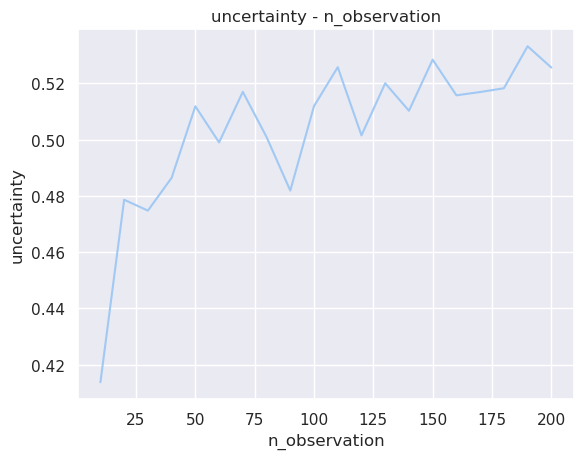

In [46]:
plt.plot(steps, list_uncertainty)
plt.ylabel('uncertainty')
plt.xlabel('n_observation')
plt.title('uncertainty - n_observation')
plt.show()

# flanker dataset

## load dataset

In [7]:
import pandas as pd
import os

In [62]:
def load_dataset():
    folder = './FlankerCSV'
    files_dataset = os.listdir(folder)
    columns = ['Subject', 'Trial', 'Coherence', 'Practice', 'Block', 'Target_Direction', 'RT', 'Acc', 'Congruency', 'Spacing']
    data = pd.DataFrame(columns=columns)

    for file_name in files_dataset:
        df = pd.read_csv(os.path.join(folder, file_name))
        df['Subject'] = file_name.split('.')[0]
        if 'N' in file_name:
            df['Spacing'] = 'Narrow'
        else:
            df['Spacing'] = 'Wide'
        # data = data.append(df[columns])
        data = pd.concat([data, df[columns]])

    data = data[data['Practice'] == 0]
    data.loc[data['Acc']==0, 'RT'] = -data.loc[data['Acc']==0, 'RT']
    data.loc[:, 'Congruency'] = 1 - data.loc[:, 'Congruency']
    data = data.reset_index(drop=True)

    return data

In [63]:
data = load_dataset()


## crossing congruency

In [64]:
experimental_settings = ['Subject', 'Coherence', 'Spacing']

In [65]:
def select_dataset(data, subject, coherence, spacing):

    df_samp = data.loc[data['Subject']==subject].loc[data['Coherence']==coherence] \
        .loc[data['Spacing']==spacing]
    return df_samp[['RT', 'Congruency']].to_numpy()

def divide_dataset(data):
    # output: array(batch, n_obs, data(options: 0/1, RTs: float)), 
    # where 1 means correct options, 0 means incorrect option.
    subjects = list(set(data['Subject']))
    coherences = list(set(data['Coherence']))
    spacings = list(set(data['Spacing']))
    coherences.sort()

    indexes = []
    data_array = []
    for subject in subjects:
        for coherence in coherences:
            for spacing in spacings:
                array = select_dataset(data, subject, coherence, spacing)
                if array.shape[0] != 0:
                    indexes.append((subject, coherence, spacing))
                    data_array.append(array)

    data_array = np.stack(data_array, axis=0).astype(np.float32)  
    data_array[data_array[:,:,0]>10, 0] = 10    
    data_array[data_array[:,:,0]<-10, 0] = -10   
    # data_array = data_array[:, 1:, :]
    indexes = pd.DataFrame(indexes, columns=experimental_settings)
    return indexes, data_array


In [66]:
indexes, data_array = divide_dataset(data)

In [67]:
data_array.dtype

dtype('float32')

In [68]:
x = torch.from_numpy(data_array).to(device)

In [69]:
alphas = evidential_net.predict(summary_net(x), to_numpy=False)

In [70]:
(alphas['m_probs'].argmax(dim=1)==0).sum()

tensor(204, device='cuda:2')

## visualization

In [71]:
indexes['model'] = (alphas['m_probs'].argmax(dim=1)==0).float().detach().cpu().numpy()
indexes['p'] = alphas['m_probs'][:,0].detach().cpu().numpy()
indexes['uncertainty'] = alphas['uncertainty'][:,0].detach().cpu().numpy()

In [72]:
indexes

,Subject,Coherence,Spacing,model,p,uncertainty
0,W19,10,Wide,1.0,0.799230,0.364512
1,W19,20,Wide,1.0,0.986906,0.026189
2,W19,40,Wide,1.0,0.982802,0.034395
3,W19,60,Wide,1.0,0.981930,0.036140
4,W19,80,Wide,1.0,0.973729,0.052542
...,...,...,...,...,...,...
199,N15,20,Narrow,1.0,0.919115,0.161580
200,N15,40,Narrow,1.0,0.962780,0.074440
201,N15,60,Narrow,1.0,0.963845,0.072310
202,N15,80,Narrow,1.0,0.965183,0.069633


In [73]:
import seaborn as sns
sns.set_theme(style="darkgrid", palette="pastel")

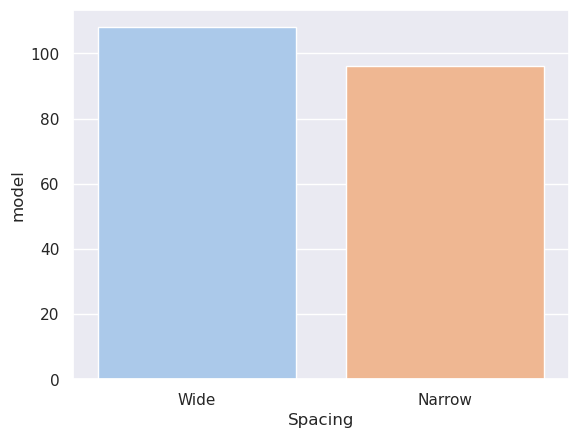

In [74]:
g = sns.barplot(data=indexes, x='Spacing', y='model', estimator=np.sum)
# g.set(ylim=(80, 100))

[(0.9, 1.0)]

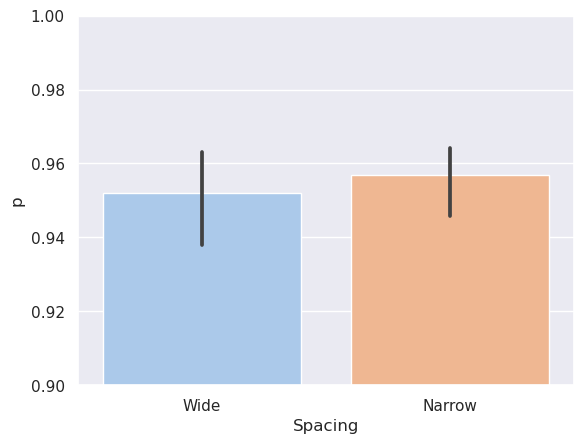

In [75]:
g = sns.barplot(data=indexes, x='Spacing', y='p', estimator=np.mean)
g.set(ylim=(0.9,1))

[(0.8, 1.0)]

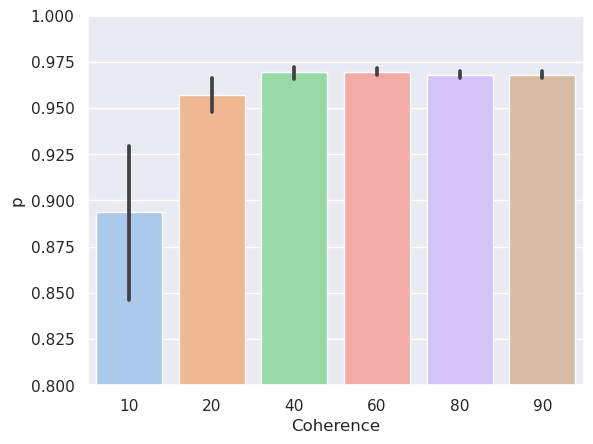

In [77]:
g = sns.barplot(data=indexes, x='Coherence', y='p', estimator=np.mean)
g.set(ylim=(0.8,1))

[(0.8, 1.0)]

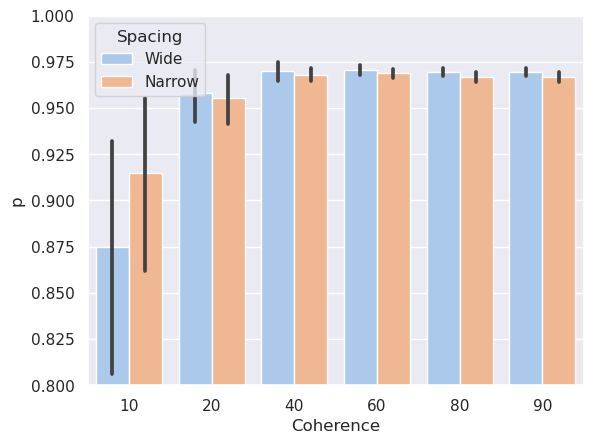

In [78]:
g = sns.barplot(data=indexes, x='Coherence', y='p', hue='Spacing', estimator=np.mean)
g.set(ylim=(0.8,1))

[(0.8, 1.0)]

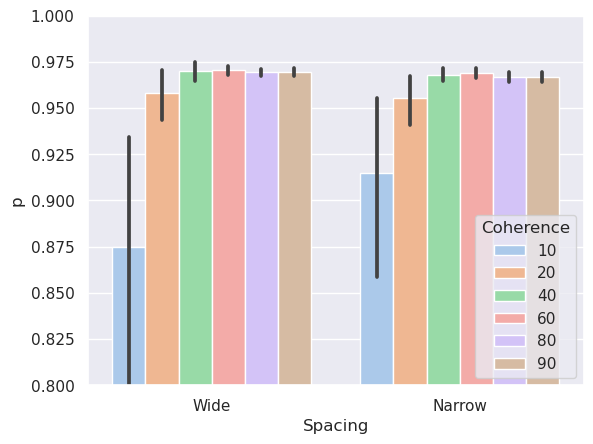

In [79]:
g = sns.barplot(data=indexes, x='Spacing', y='p', hue='Coherence', estimator=np.mean)
g.set(ylim=(0.8,1))

<AxesSubplot:xlabel='Coherence', ylabel='uncertainty'>

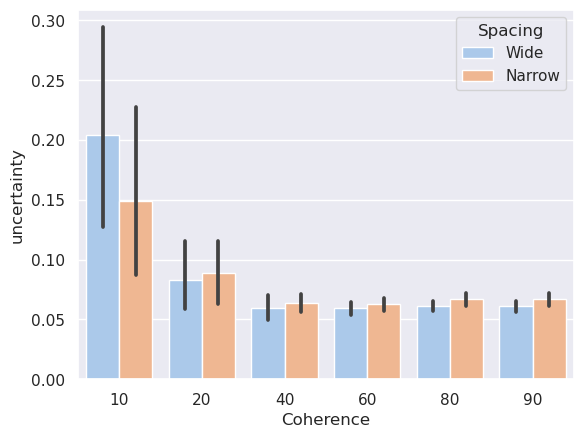

In [25]:
sns.barplot(data=indexes, x='Coherence', y='uncertainty', hue='Spacing', estimator=np.mean)

<AxesSubplot:xlabel='Spacing', ylabel='uncertainty'>

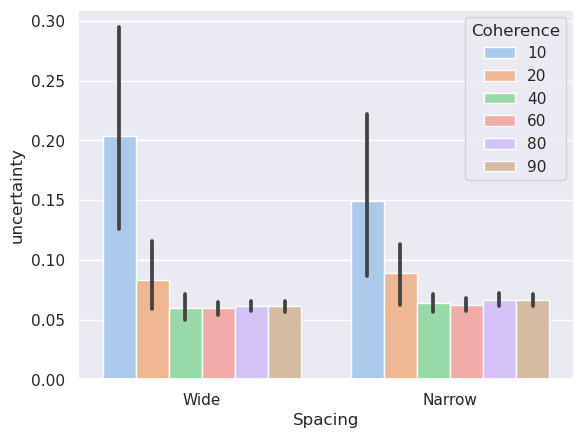

In [26]:
sns.barplot(data=indexes, x='Spacing', y='uncertainty', hue='Coherence', estimator=np.mean)

## seperate congruency

In [27]:
experimental_settings = ['Subject', 'Coherence', 'Spacing', 'Congruency']

In [28]:
def select_dataset(data, subject, coherence, spacing, congruency):

    df_samp = data.loc[data['Subject']==subject].loc[data['Coherence']==coherence] \
        .loc[data['Spacing']==spacing].loc[data['Congruency']==congruency]
    return df_samp[['RT', 'Congruency']].to_numpy()

def divide_dataset(data):
    # output: array(batch, n_obs, data(options: 0/1, RTs: float)), 
    # where 1 means correct options, 0 means incorrect option.
    subjects = list(set(data['Subject']))
    coherences = list(set(data['Coherence']))
    spacings = list(set(data['Spacing']))
    congruences = list(set(data['Congruency']))
    coherences.sort()

    indexes = []
    data_array = []
    for subject in subjects:
        for coherence in coherences:
            for spacing in spacings:
                for congruency in congruences:
                    array = select_dataset(data, subject, coherence, spacing, congruency)
                    if array.shape[0] != 0:
                        indexes.append((subject, coherence, spacing, congruency))
                        data_array.append(array)

    data_array = np.stack(data_array, axis=0).astype(np.float32)  
    data_array[data_array[:,:,0]>10, 0] = 10    
    data_array[data_array[:,:,0]<-10, 0] = -10   
    # data_array = data_array[:, 1:, :]
    indexes = pd.DataFrame(indexes, columns=experimental_settings)
    indexes.loc[indexes['Congruency']==1, 'Congruency'] = 'Incongruency'
    indexes.loc[indexes['Congruency']==0, 'Congruency'] = 'Congruency'
    return indexes, data_array

In [29]:
indexes, data_array = divide_dataset(data)

In [30]:
data_array.dtype

dtype('float32')

In [31]:
x = torch.from_numpy(data_array).to(device)

In [32]:
alphas = evidential_net.predict(summary_net(x), to_numpy=False)

In [33]:
(alphas['m_probs'].argmax(dim=1)==0).sum()

tensor(407, device='cuda:2')

## visualization

In [34]:
indexes['model'] = (alphas['m_probs'].argmax(dim=1)==0).float().detach().cpu().numpy()
indexes['p'] = alphas['m_probs'][:,0].detach().cpu().numpy()
indexes['uncertainty'] = alphas['uncertainty'][:,0].detach().cpu().numpy()

In [35]:
indexes

,Subject,Coherence,Spacing,Congruency,model,p,uncertainty
0,W19,10,Wide,Congruency,1.0,0.610374,0.549499
1,W19,10,Wide,Incongruency,1.0,0.906306,0.186742
2,W19,20,Wide,Congruency,1.0,0.987835,0.024330
3,W19,20,Wide,Incongruency,1.0,0.985774,0.028453
4,W19,40,Wide,Congruency,1.0,0.980136,0.039727
...,...,...,...,...,...,...,...
403,N15,60,Narrow,Incongruency,1.0,0.962538,0.074924
404,N15,80,Narrow,Congruency,1.0,0.966336,0.067329
405,N15,80,Narrow,Incongruency,1.0,0.963997,0.072005
406,N15,90,Narrow,Congruency,1.0,0.965345,0.069310


<AxesSubplot:xlabel='Congruency', ylabel='p'>

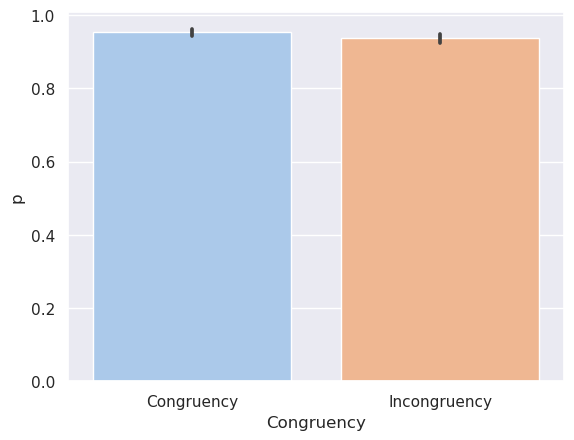

In [36]:
sns.barplot(data=indexes, x='Congruency', y='p', estimator=np.mean)

<AxesSubplot:xlabel='Congruency', ylabel='p'>

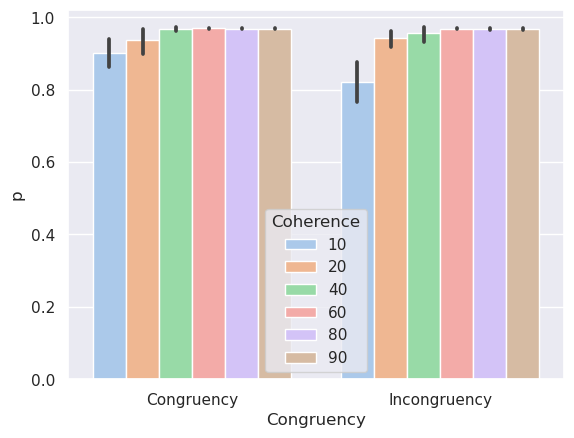

In [37]:
sns.barplot(data=indexes, x='Congruency', y='p', hue='Coherence', estimator=np.mean)

<AxesSubplot:xlabel='Congruency', ylabel='p'>

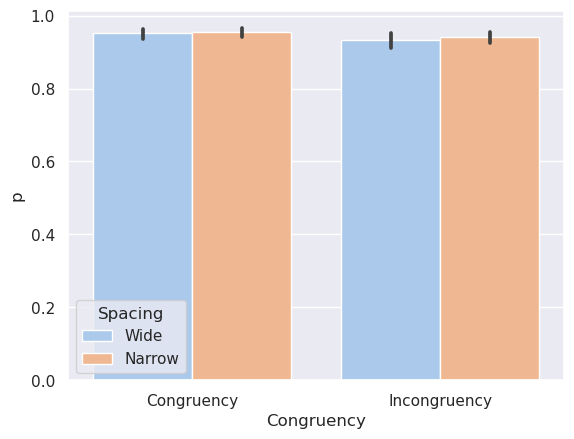

In [38]:
sns.barplot(data=indexes, x='Congruency', y='p', hue='Spacing', estimator=np.mean)